# Imports

In [2]:
import datetime
import talib as ta
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from backtesting import Backtest, Strategy
from backtesting.lib import crossover, plot_heatmaps


# Load & Process data

In [3]:
from backtesting.test import GOOG

factor = 1_000_000
GOOG['Open'] /= factor
GOOG['High'] /= factor
GOOG['Low'] /= factor
GOOG['Close'] /= factor

data = GOOG

# Strategy Class

In [9]:
size = 4

def indicator(data):
    # % increase in stock over 7 periods
    return data.pct_change(periods = 7) * 100

class Strategy(Strategy):
 
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    
    # Do as much initial computation as possible
    def init(self):
        self.rsi = self.I(ta.RSI, self.data.Close, self.rsi_window)

    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):
        price = self.data.Close[-1]
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            stop = price - 0.1*price
            oneR = abs(price - stop)
            take_profit = price + (1.2 * oneR)
            self.buy(size=size-1,sl=stop,tag=[oneR,size,"initial"])
            self.buy(size=1,sl=stop,tp=take_profit,tag=[oneR,size,"portion"])

# Test Run

# Single Run Test

In [14]:
bt = Backtest(data, Strategy, cash=100, commission=.002)
stats = bt.run(rsi_window=7)

print(stats)
print(stats._strategy)

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                    39.61825
Equity Final [$]                   101.607154
Equity Peak [$]                     110.58054
Return [R]                           1.607154
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                    0.187225
Volatility (Ann.) [%]                3.330597
Max. Drawdown [%]                  -15.801018
Avg. Drawdown [%]                   -1.068069
Max. Drawdown Duration     1912 days 00:00:00
Avg. Drawdown Duration       94 days 00:00:00
# Trades                                   77
Win Rate [%]                        62.337662
Best Trade [R]                       2.197541
Worst Trade [R]                     -1.748345
Expectancy (mean R)                  0.020872
Profit Factor                        1.055255
SQN                                  0.204931
SQN100                            

# Optimise Test

In [21]:
bt = Backtest(data, Strategy, cash=100, commission=.002)
stats, heatmap, optimize_result  = bt.optimize(
    upper_bound = [50, 100],
    lower_bound = [20, 50],
    rsi_window = [5, 30],
    maximize = "SQN",
    method = "skopt",
    constraint = lambda param: param.upper_bound > param.lower_bound,
    max_tries = 50,
    random_state=0,
    return_heatmap=True,
    return_optimization=True
    )

bt.plot(resample=False)

trades = stats['_trades'].drop('ReturnPct', axis=1)
trades.Size /= size
trades.EntryPrice = round(trades.EntryPrice * factor,2)
trades.ExitPrice = round(trades.ExitPrice * factor,2)
trades.PnL = round(trades.PnL,2)
trades.OneR = round(trades.OneR * factor,2)

print(stats)
print(trades.to_string())
print(str(stats._strategy))

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   82.029795
Equity Final [$]                   256.891517
Equity Peak [$]                    258.499989
Return [R]                         156.891517
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                   11.704637
Volatility (Ann.) [%]               10.819124
Max. Drawdown [%]                  -11.314314
Avg. Drawdown [%]                   -1.575276
Max. Drawdown Duration      651 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                   93
Win Rate [%]                         63.44086
Best Trade [R]                      15.096072
Worst Trade [R]                     -1.909223
Expectancy (mean R)                  1.687006
Profit Factor                        5.244177
SQN                                  4.799303
SQN100                            

# Walk forward

In [4]:
def walk_forward(
    strategy,
    data_full,
    warmup_bars,
    lookback_bars,
    validation_bars,
    cash = 100,
    commission = 0.002/factor
    ):

    stats_master = []

    for i in range(lookback_bars + warmup_bars, len(data_full) - validation_bars, validation_bars):
        
        training_data = data_full.iloc[i-lookback_bars-warmup_bars:i]
        validation_data = data_full.iloc[i-warmup_bars:i+validation_bars]

        bt_training = Backtest(training_data, strategy, cash=cash, commission=commission)
        stats_training = bt_training.optimize(
            upper_bound = [50, 100],
            lower_bound = [20, 50],
            rsi_window = [5, 30],
            maximize = "SQN",
            method = "skopt",
            constraint = lambda param: param.upper_bound > param.lower_bound,
            max_tries = 50,
            random_state=0,
            #return_heatmap=True,
            #return_optimization=True
            )
        
        lower_bound = stats_training._strategy.lower_bound
        upper_bound = stats_training._strategy.upper_bound
        rsi_window = stats_training._strategy.rsi_window

        bt_validation = Backtest(validation_data, strategy, cash=cash, commission=commission)
        stats_validation = bt_validation.run(
                lower_bound = 50,#lower_bound,
                upper_bound = 78,#upper_bound,
                rsi_window = 14#rsi_window,
                                )
        stats_master.append(stats_validation)

    return stats_master

# Run Walk-Forward

In [34]:
size = 4
lookback_bars = 365
validation_bars = 182
warmup_bars = 30

stats = walk_forward(
    Strategy,
    data,
    lookback_bars=lookback_bars,
    validation_bars=validation_bars,
    warmup_bars=warmup_bars)

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

# Plots

# Plot stats of a particular result

In [35]:
def plot_stats(data_full, stats):
    equity_curve = stats._equity_curve
    aligned_data = data_full.reindex(equity_curve.index)
    
    bt = Backtest(aligned_data, Strategy, cash=100, commission=0.002)
    bt.plot(results = stats)

In [47]:
plot_stats(data, stats[4])

# Plot full equity curve of all validation tests

In [42]:
def plot_full_equity_curve(
    data,
    stats_list,
    warmup_bars,
    lookback_bars):
    
    equity_curves = [x["_equity_curve"].iloc[warmup_bars:] for x in stats_list]
    
    combined = pd.Series(dtype="float64")
    for curve in equity_curves:
        if len(combined) == 0:
            combined = curve["Equity"]/100
        else:
            combined = pd.concat([combined, (curve["Equity"]/100)*combined.iloc[-1]]) 
                                             
    aligned_price_data = data[data.index <= combined.index[-1]].iloc[lookback_bars + warmup_bars:]
    
    fig, ax1 = plt.subplots()
    ax1.plot(combined.index, combined, color="orange")
    ax2 = ax1.twinx()
    ax2.plot(aligned_price_data.index, aligned_price_data.Close*factor)
    
    plt.show()

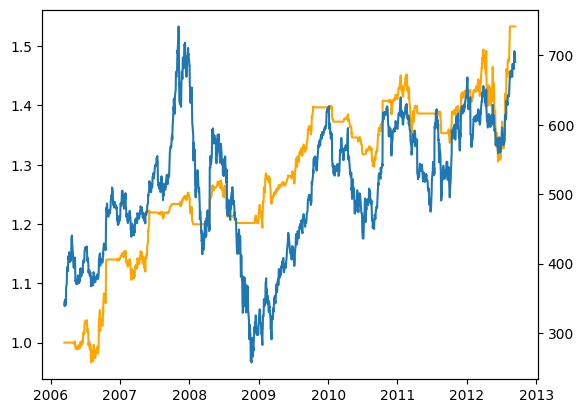

In [43]:
plot_full_equity_curve(data, stats, warmup_bars, lookback_bars)

# Plot walkforward periods

In [26]:
def plot_period_graph(
    data,
    lookback_bars,
    validation_bars):
    
    ranges = list(range(lookback_bars + warmup_bars, len(data) - validation_bars, validation_bars))
    
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    
    for i in range(len(ranges)):
        
        training_data = data.iloc[ranges[i]-lookback_bars:ranges[i]]
        validation_data = data.iloc[ranges[i]:ranges[i]+validation_bars]
        
        plt.fill_between(training_data.index,
                        [len(ranges) - i - 0.5]*len(training_data.index),
                        [len(ranges) - i + 0.5]*len(training_data.index),
                         color = "blue"
                        )
        
        plt.fill_between(validation_data.index,
                        [len(ranges) - i - 0.5]*len(validation_data.index),
                        [len(ranges) - i + 0.5]*len(validation_data.index),
                         color = "orange"
                        )
    
    plt.show()

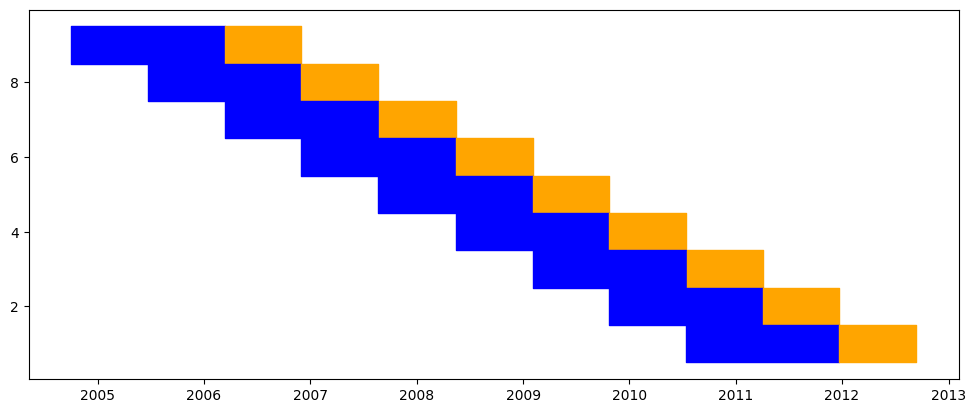

In [27]:
plot_period_graph(data,lookback_bars,validation_bars)